# Notebook for 8/30/2021 seminar on Haliburton pmag pole 

The current goal of this notebook is to show the Laurentia paleomagnetic pole compilation in the Mesoproterozoic to Neoproterozoic from the older Logan Loop to the Keweenawan Track and to the younger Grenville Loop. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmagpy.pmag as pmag
import pmagpy.ipmag as ipmag
import matplotlib
import matplotlib.colors as colors
from scipy.constants import Julian_year
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
Laurentia_outline = ShapelyFeature(Reader('../data/Laurentia_shape/Laurentia.shp').geometries(),
                                ccrs.PlateCarree(), facecolor = 'none', edgecolor='black')
Grenville_shp = ShapelyFeature(Reader('../data/Grenville_shape/ROXGREG_merge.shp').geometries(), ccrs.PlateCarree(), facecolor='g', edgecolor='None', alpha = 0.8)

In [3]:
d2r = np.pi/180
r2d = 180/np.pi
def rotate(pole, rotation_pole, angle):
    # assume lon lat as entries
    # The idea is to rotate the pole so that the Euler pole is
    # at the pole of the coordinate system, then perform the
    # requested rotation, then restore things to the original
    # orientation
    pole = spherical_to_cartesian(pole[0], pole[1])
    
    lon, lat, intensity = rotation_pole[0], rotation_pole[1], 1
    
    colat = 90. - lat
    m1 = construct_euler_rotation_matrix(-lon
                                         * d2r, -colat * d2r, angle * d2r)
    m2 = construct_euler_rotation_matrix(0., colat * d2r, lon * d2r)
#     print(cartesian_to_spherical(np.dot(m2, np.dot(m1, pole)))[:2])
    return cartesian_to_spherical(np.dot(m2, np.dot(m1, pole)))[:2]


def construct_euler_rotation_matrix(alpha, beta, gamma):
    """
    Make a 3x3 matrix which represents a rigid body rotation,
    with alpha being the first rotation about the z axis,
    beta being the second rotation about the y axis, and
    gamma being the third rotation about the z axis.

    All angles are assumed to be in radians
    """
    rot_alpha = np.array([[np.cos(alpha), -np.sin(alpha), 0.],
                          [np.sin(alpha), np.cos(alpha), 0.],
                          [0., 0., 1.]])
    rot_beta = np.array([[np.cos(beta), 0., np.sin(beta)],
                         [0., 1., 0.],
                         [-np.sin(beta), 0., np.cos(beta)]])
    rot_gamma = np.array([[np.cos(gamma), -np.sin(gamma), 0.],
                          [np.sin(gamma), np.cos(gamma), 0.],
                          [0., 0., 1.]])
    rot = np.dot(rot_gamma, np.dot(rot_beta, rot_alpha))
    return rot

def spherical_to_cartesian(longitude, latitude, norm = 1):
    #    assert(np.all(longitude >= 0.) and np.all(longitude <= 360.))
    #    assert(np.all(latitude >= -90.) and np.all(latitude <= 90.))
    #    assert(np.all(norm >= 0.))
    colatitude = 90. - latitude
    return np.array([norm * np.sin(colatitude * d2r) * np.cos(longitude * d2r),
                     norm * np.sin(colatitude * d2r) * np.sin(longitude * d2r),
                     norm * np.cos(colatitude * d2r)])

def cartesian_to_spherical(vecs):
    v = np.reshape(vecs, (3, -1))
    norm = np.sqrt(v[0, :] * v[0, :] + v[1, :] * v[1, :] + v[2, :] * v[2, :])
    latitude = 90. - np.arccos(v[2, :] / norm) * r2d
    longitude = np.arctan2(v[1, :],v[0, :]) * r2d
    
    return np.ndarray.flatten(np.array([longitude, latitude, norm]))

## the Laurentia APWP

In [15]:
Previous_Laurentia_poles = pd.read_csv('../data/Laurentia_poles/Laurentia_poles.csv')[10:28].reset_index(drop=1)
Previous_Grenville_poles = pd.read_csv('../data/Laurentia_poles/Laurentia_poles.csv')[28:33].reset_index(drop=1)
Kewee_poles = pd.read_csv('../data/Laurentia_poles/Laurentia_poles.csv')
Kewee_poles = Kewee_poles[8:28]
Grenville_poles = pd.read_csv('code_output/pole_means.csv')

Laurentia_poles = pd.concat([Kewee_poles, Grenville_poles]).reset_index(drop=1)

In [16]:
Grenville_poles

,PoleName,SLat,SLon,PLat,PLon,A95,K,N,PolarityZone,PmagRef,AgeNominal,AgeLower,AgeUpper,AgeInfo,AgeRef,Gaussian_2sigma,GaussianOrUniform,Q,color
0,Whitestone pole,45.66,-79.87,-18.3,148.7,6.9,57.4,9,AR,"Ueno et al., 1975a",954.4,943.1,965.7,see thermal history,"Dallmeyer et a., 1980",NaN,gaussian,NaN,#B82431
1,Haliburton pole,44.95,-78.44,-35.1,141.6,5.2,18.6,42,AR,"Buchan et al., 1973, 1976; Warnock et al., 2000",924.1,918.7,929.5,see thermal history,Berger and York 1981; Warnock 2000; Cosca 1992...,NaN,gaussian,NaN,#0000FF
2,Adirondack pole,44.20,-74.00,-23.7,142.9,6.7,13.7,36,AR+AN,"Brown et al., 2012",923.5,915.5,931.5,see thermal history,"Mezger et al., 1989, 1991, 1992; Streepey et a...",NaN,gaussian,NaN,#930E26
3,Allard Urbain pole,44.20,-74.00,-10.6,154.0,11.2,11.1,17,AR+AN,"Hargraves 1967, 1974; Robertson 1979",892.0,889.3,894.7,see thermal history,"Morisset et al., 2009",NaN,gaussian,NaN,#3B7185


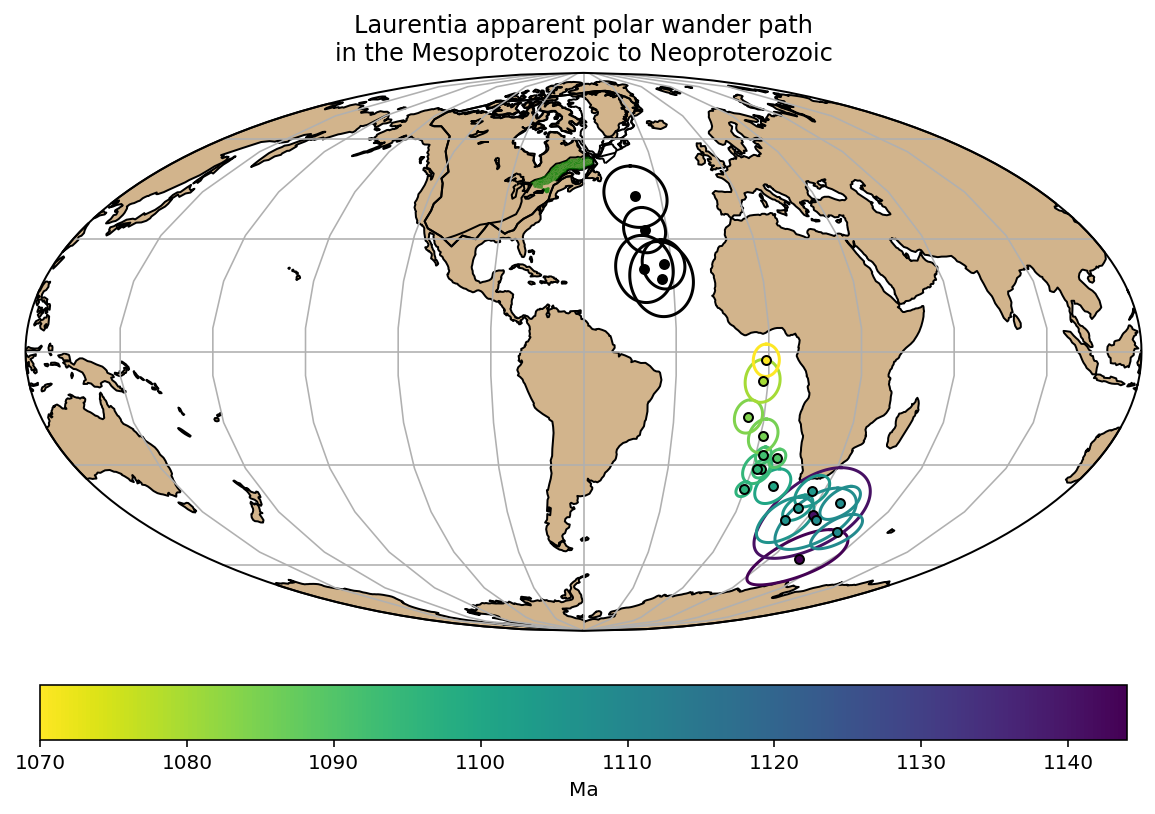

In [17]:
# plt.figure(figsize=(6, 6))
m = ipmag.make_mollweide_map(central_longitude=300, figsize=(10, 10), land_color = 'tan')
m.add_feature(Laurentia_outline)
m.add_feature(Grenville_shp)
viridis = cm = plt.get_cmap('viridis') 
cNorm  = matplotlib.colors.Normalize(vmin=Previous_Laurentia_poles.AgeNominal.min(), vmax=Previous_Laurentia_poles.AgeNominal.max())
Laurentia_scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap='viridis_r')


for n in Previous_Laurentia_poles.index:
    rgba = Laurentia_scalarMap.to_rgba(Previous_Laurentia_poles.AgeNominal[n])
    hex_color = colors.rgb2hex(rgba)
    ipmag.plot_pole(m,180+Previous_Laurentia_poles.PLon[n],-Previous_Laurentia_poles.PLat[n],Previous_Laurentia_poles.A95[n],color=hex_color)
    
    
Laurentia_scalarMap.set_array(np.linspace(Previous_Laurentia_poles.AgeNominal.min(),Previous_Laurentia_poles.AgeNominal.max()))    
plt.colorbar(Laurentia_scalarMap,orientation='horizontal',fraction=0.05, pad=0.05, label='Ma')

ipmag.plot_poles(m, [180+i for i in Previous_Grenville_poles.PLon.tolist()], [-i for i in Previous_Grenville_poles.PLat.tolist()], Previous_Grenville_poles.A95.tolist(), color='k')

plt.title('Laurentia apparent polar wander path\nin the Mesoproterozoic to Neoproterozoic')
# plt.savefig('../figure/Kewee_Grenville_Loop.pdf', bbox_inches='tight')
plt.show()

<Figure size 432x432 with 0 Axes>

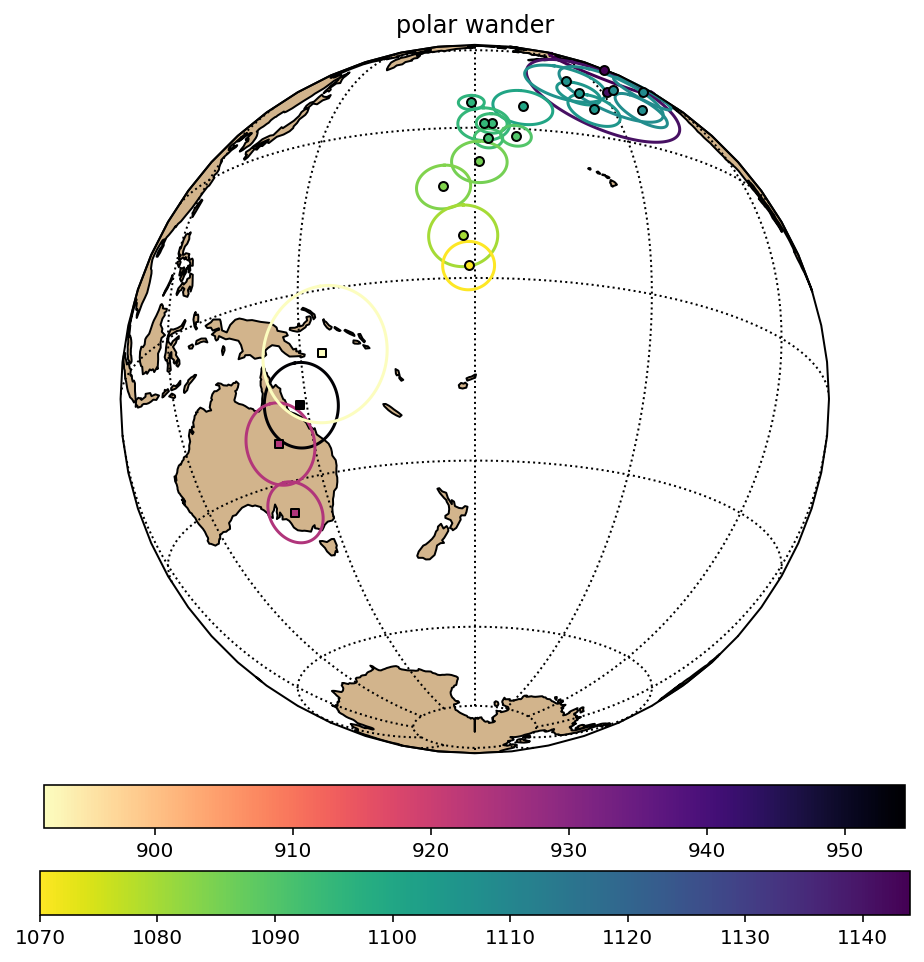

In [19]:
plt.figure(figsize=(6, 6))
m = ipmag.make_orthographic_map(central_longitude=180, central_latitude=-20)

# viridis = cm = plt.get_cmap('viridis') 
Laurentia_cNorm  = matplotlib.colors.Normalize(vmin=Previous_Laurentia_poles.AgeNominal.min(), vmax=Previous_Laurentia_poles.AgeNominal.max())
Laurentia_scalarMap = matplotlib.cm.ScalarMappable(norm=Laurentia_cNorm, cmap='viridis_r')


for n in Previous_Laurentia_poles.index:
    rgba = Laurentia_scalarMap.to_rgba(Previous_Laurentia_poles.AgeNominal[n])
    hex_color = colors.rgb2hex(rgba)
    ipmag.plot_pole(m,Previous_Laurentia_poles.PLon[n],Previous_Laurentia_poles.PLat[n],Previous_Laurentia_poles.A95[n],color=hex_color)
    
Grenville_cNorm  = matplotlib.colors.Normalize(vmin=Grenville_poles.AgeNominal.min(), vmax=Grenville_poles.AgeNominal.max())
Grenville_scalarMap = matplotlib.cm.ScalarMappable(norm=Grenville_cNorm, cmap='magma_r') 
for n in Grenville_poles.index:
    rgba = Grenville_scalarMap.to_rgba(Grenville_poles.AgeNominal[n])
    hex_color = colors.rgb2hex(rgba)
    ipmag.plot_pole(m,Grenville_poles.PLon[n],Grenville_poles.PLat[n],Grenville_poles.A95[n],color=hex_color, marker = 's')
    
Laurentia_scalarMap.set_array(np.linspace(Laurentia_poles.AgeNominal.min(),Laurentia_poles.AgeNominal.max()))    
plt.colorbar(Laurentia_scalarMap,orientation='horizontal',fraction=0.05, pad=0.05)
plt.colorbar(Grenville_scalarMap,orientation='horizontal',fraction=0.055, pad=0.04)


plt.title('polar wander')
plt.savefig('../figure/Kewee_Grenville_Loop.pdf', bbox_inches='tight')
plt.show()

In [6]:
pmag.angle([141.6, -35.1], [190, -16])

array([47.10619417160583])

## Baltica APWP

In [5]:
Baltica_poles = pd.read_csv('../data/Baltica_poles/Baltica_poles.csv', encoding='iso-8859-1')
# Baltica_poles['A95'] = Baltica_poles['A95'].fillna(0)
Baltica_poles['Laurentia_PLon'] = [rotate([Baltica_poles['PLon'][i], Baltica_poles['PLat'][i]], 
                                          [95.7, 75.8], -59.2)[0] for i in range(Baltica_poles.shape[0])]
Baltica_poles['Laurentia_PLat'] = [rotate([Baltica_poles['PLon'][i], Baltica_poles['PLat'][i]], 
                                          [95.7, 75.8], -59.2)[1] for i in range(Baltica_poles.shape[0])]
Baltica_poles

,PoleName,Dec,Inc,PLat,PLon,A95,K,N,PolarityZone,PmagRef,...,AgeLower,AgeUpper,AgeInfo,AgeRef,Gaussian_2sigma,GaussianOrUniform,Q,color,Laurentia_PLon,Laurentia_PLat
0,Hunnedalen dykes,294.0,-75.0,-41.0,222.0,10.5,115.0,6.0,NaN,"Walderhaug, H.J., Torsvik, T.H., Eide, E.A., S...",...,821.0,875.0,Ar biotite age,NaN,NaN,gaussian,NaN,NaN,166.633048,-54.766188
1,Egersund-Ogna anorthosite,325.9,-80.1,-42.1,200.4,9.0,73.0,13.0,NaN,"Brown, L.L., McEnroe, S.A., 2004. Palaeomagnet...",...,NaN,NaN,Cooling age,NaN,NaN,NaN,NaN,NaN,138.205762,-55.468350
2,Egersund anorthosite,NaN,NaN,-43.5,213.7,3.6,NaN,76.0,NaN,"Stearn, J.E.F., Piper, J.D.A., 1984. Palaeomag...",...,NaN,NaN,Cooling age,NaN,NaN,NaN,NaN,NaN,155.722577,-57.416977
3,Rogaland Igneous Complex,269.0,-72.0,-45.9,238.4,18.2,49.0,5.0,NaN,"Walderhaug, H.J., Torsvik, T.H., Halvorsen, E....",...,855.0,883.0,Ar biotite age,NaN,NaN,gaussian,NaN,NaN,-170.829384,-58.226649
4,Bjerkreim-Sokndal intrusion,303.4,-73.5,-35.9,217.9,6.0,24.0,66.0,NaN,"Brown, L.L., McEnroe, S.A., 2015. 916 Ma pole ...",...,NaN,NaN,Cooling age,NaN,NaN,NaN,NaN,NaN,161.071518,-49.789293
5,Mean 951Ð935 Ma Baltica pole,308.8,-39.6,-2.6,239.6,5.8,42.0,12.0,NaN,"Gong, Z., Evans, D. A., Elming, S. ., Sderlu...",...,935.0,951.0,U-Pb baddeleyite age,NaN,NaN,gaussian,NaN,NaN,-177.142556,-15.171944
6,971 Ma BDD dykes VGP,307.6,-65.4,-27.0,230.4,14.9,68.0,4.0,NaN,"Gong, Z., Evans, D. A., Elming, S. ., Sderlu...",...,964.0,978.0,U-Pb baddeleyite age,NaN,NaN,gaussian,NaN,NaN,175.474544,-40.303376
7,Laanila-Ristija_rvi dykes,355.5,-40.0,-2.1,212.2,16.4,51.0,3.0,NaN,"Mertanen, S., Pesonen, L.J., Huhma, H., 1996. ...",...,992.0,1092.0,Sm-Nd whole-rock age,NaN,NaN,gaussian,NaN,NaN,154.422040,-16.007010
8,Bamble Intrusion mean,NaN,NaN,3.0,217.0,15.0,NaN,NaN,NaN,"Meert, J.G., Torsvik, T.H., 2003. The making a...",...,1040.0,1100.0,NaN,NaN,NaN,uniform,NaN,NaN,159.356744,-10.906093


## Plot Mesoproteozoic - Neoproterozoic APWPs

<Figure size 432x432 with 0 Axes>

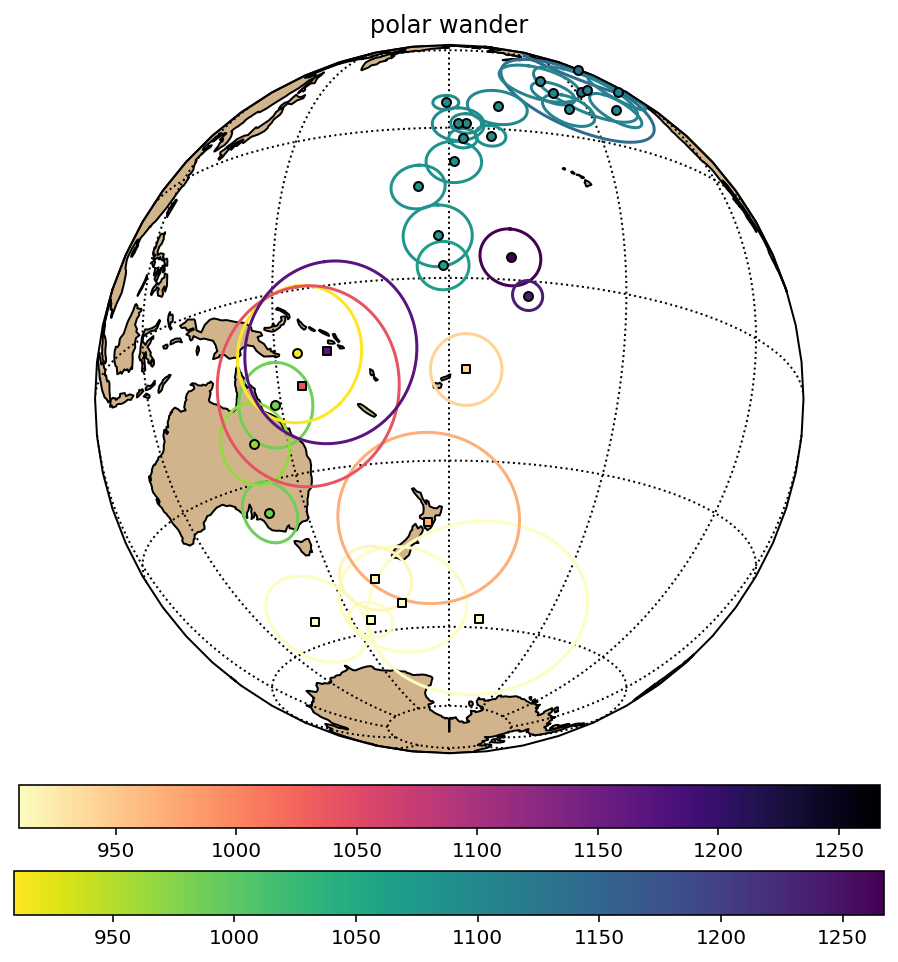

In [6]:
plt.figure(figsize=(6, 6))
m = ipmag.make_orthographic_map(central_longitude=180, central_latitude=-20)

viridis = cm = plt.get_cmap('viridis') 
cNorm  = matplotlib.colors.Normalize(vmin=Laurentia_poles.AgeNominal.min(), vmax=Laurentia_poles.AgeNominal.max())
Laurentia_scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap='viridis_r')


for n in Laurentia_poles.index:
    rgba = Laurentia_scalarMap.to_rgba(Laurentia_poles.AgeNominal[n])
    hex_color = colors.rgb2hex(rgba)
    ipmag.plot_pole(m,Laurentia_poles.PLon[n],Laurentia_poles.PLat[n],Laurentia_poles.A95[n],color=hex_color)
    
Baltica_scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap='magma_r') 
for n in Baltica_poles.index:
    rgba = Baltica_scalarMap.to_rgba(Baltica_poles.AgeNominal[n])
    hex_color = colors.rgb2hex(rgba)
    ipmag.plot_pole(m,Baltica_poles.Laurentia_PLon[n],Baltica_poles.Laurentia_PLat[n],Baltica_poles.A95[n],color=hex_color, marker = 's')
    
Laurentia_scalarMap.set_array(np.linspace(Laurentia_poles.AgeNominal.min(),Laurentia_poles.AgeNominal.max()))    
plt.colorbar(Laurentia_scalarMap,orientation='horizontal',fraction=0.05, pad=0.05)
plt.colorbar(Baltica_scalarMap,orientation='horizontal',fraction=0.055, pad=0.04)


plt.title('polar wander')
# plt.savefig('../figure/Logan_Kewee_Grenville_Loop.pdf', bbox_inches='tight')
plt.show()

<Figure size 432x432 with 0 Axes>

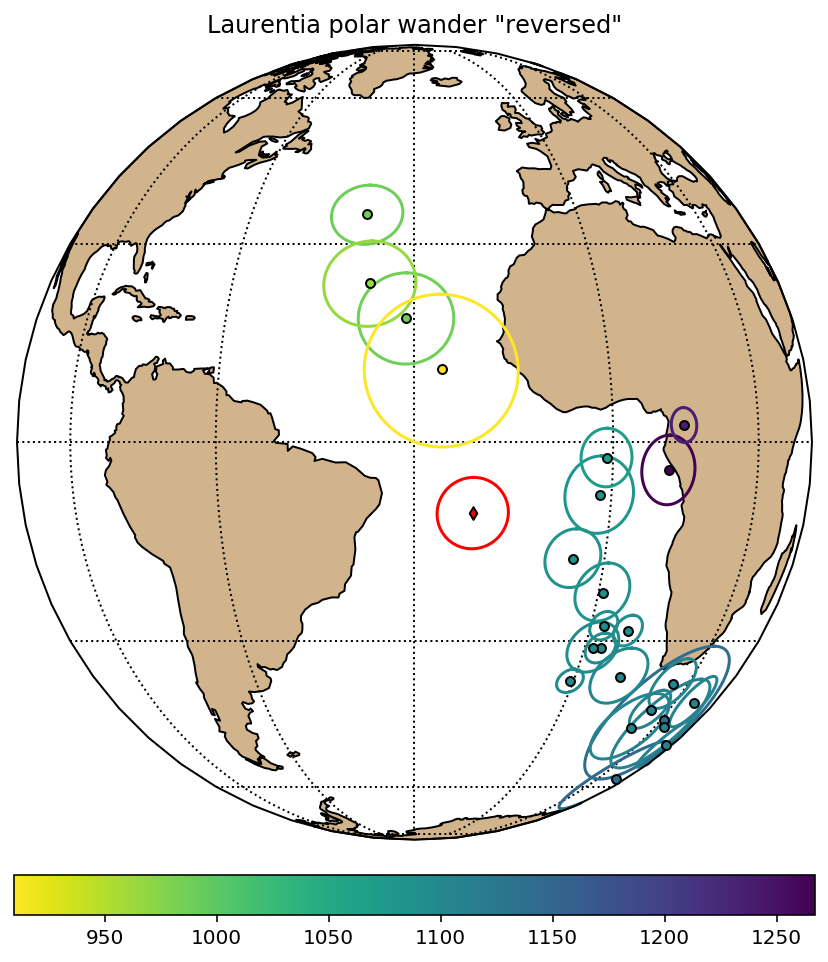

In [7]:
plt.figure(figsize=(6, 6))
m = ipmag.make_orthographic_map(central_longitude=330, central_latitude=0)

viridis = cm = plt.get_cmap('viridis') 
cNorm  = matplotlib.colors.Normalize(vmin=Laurentia_poles.AgeNominal.min(), vmax=Laurentia_poles.AgeNominal.max())

scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap='viridis_r')
# scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap='Spectral_r')

for n in Laurentia_poles.index:
    rgba = scalarMap.to_rgba(Laurentia_poles.AgeNominal[n])
    hex_color = colors.rgb2hex(rgba)
    hex_color
    ipmag.plot_pole(m,Laurentia_poles.PLon[n]-180,-Laurentia_poles.PLat[n],Laurentia_poles.A95[n],color=hex_color)
  
# for n in Grenville_poles.index:
#     rgba = scalarMap.to_rgba(Grenville_poles.AgeNominal[n])
#     hex_color = colors.rgb2hex(rgba)
#     hex_color
#     ipmag.plot_pole(m,Grenville_poles.PLon[n]-180,-Grenville_poles.PLat[n],Grenville_poles.A95[n],color=hex_color)
    
ipmag.plot_pole(m, 338.6, -10.3, 5.2, marker = 'd', color = 'r', label = 'Halls P pole')




scalarMap.set_array(np.linspace(Laurentia_poles.AgeNominal.min(), Laurentia_poles.AgeNominal.max()))    
plt.colorbar(scalarMap,orientation='horizontal',fraction=0.046, pad=0.04)
plt.title('Laurentia polar wander "reversed"')
# plt.savefig('../figure/Logan_Kewee_Grenville_Loop_rev.pdf', bbox_inches='tight')
plt.show()

<Figure size 432x432 with 0 Axes>

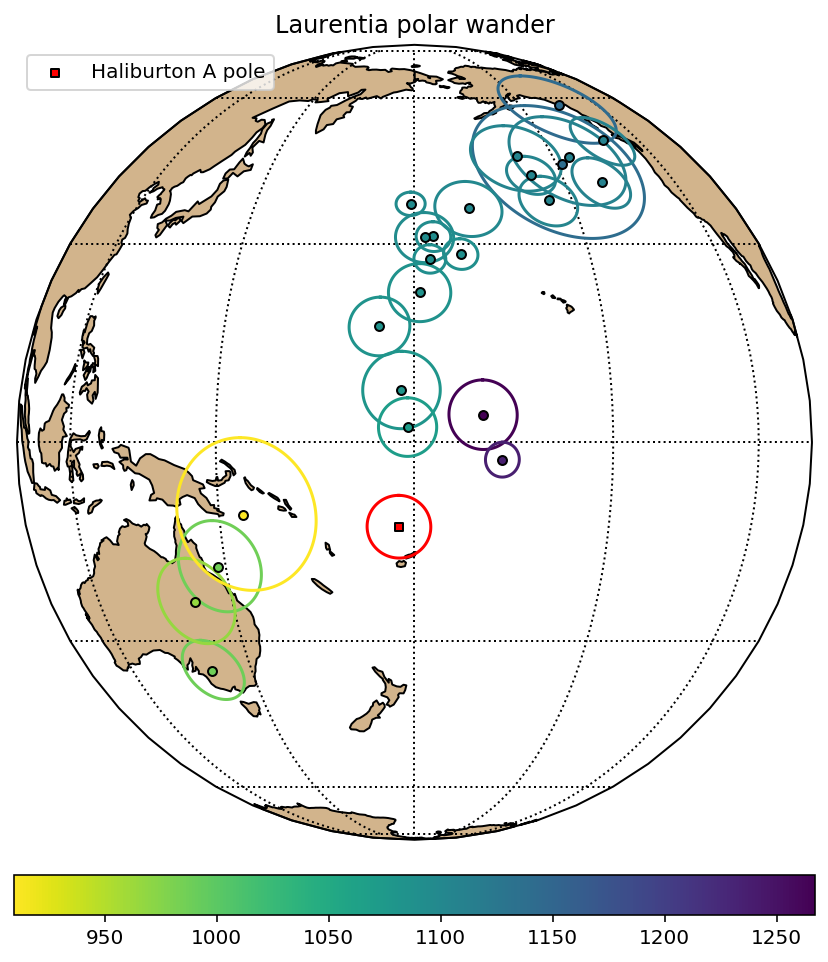

In [8]:
plt.figure(figsize=(6, 6))
m = ipmag.make_orthographic_map(central_longitude=180, central_latitude=0)

viridis = cm = plt.get_cmap('viridis') 
cNorm  = matplotlib.colors.Normalize(vmin=Laurentia_poles.AgeNominal.min(), vmax=Laurentia_poles.AgeNominal.max())

scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap='viridis_r')
# scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap='Spectral_r')

for n in Laurentia_poles.index:
    rgba = scalarMap.to_rgba(Laurentia_poles.AgeNominal[n])
    hex_color = colors.rgb2hex(rgba)
    hex_color
    ipmag.plot_pole(m,Laurentia_poles.PLon[n],Laurentia_poles.PLat[n],Laurentia_poles.A95[n],color=hex_color)  

ipmag.plot_pole(m, 177.7, -12.3, 4.6, marker = 's', color = 'r', label = 'Haliburton A pole')


# ipmag.plot_pole(m, 142.5, -36, 6, marker = 'o', color = 'r', label = 'Haliburton A pole')
# ipmag.plot_pole(m, 172.3, 24.5, 16, marker = 's', color = 'r', label = 'Haliburton B pole')
# ipmag.plot_pole(m, 167, -3, 7, marker = 'd', color = 'r', label = 'Haliburton C pole')

# ipmag.plot_pole(m, 180-338.6, 10.3, 5.2, marker = 'd', color = 'r', label = 'Halls P pole')
# ipmag.plot_pole(m, 180-345.5, -5.1, 5.2, marker = 'd', color = 'g', label = 'Halls B pole')
# ipmag.plot_pole(m, 180-348.5, 17.4, 5.2, marker = 'd', color = 'b', label = 'Halls C pole')


plt.colorbar(scalarMap,orientation='horizontal',fraction=0.046, pad=0.04)
plt.title('Laurentia polar wander')
plt.legend()
# plt.savefig('../figure/Buchan1978_components.pdf', bbox_inches='tight')
plt.show()